<a href="https://colab.research.google.com/github/forcoding1/Deep-Learning-with-tensorflow/blob/main/08_intro_to_nlp_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Jun  4 15:48:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-04 15:48:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-04 15:48:26 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import tensorflow as tf
from helper_functions import plot_loss_curves, create_tensorboard_callback, unzip_data, compare_historys

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

unzip_data("nlp_getting_started.zip")

--2023-06-04 15:48:29--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 142.251.167.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2023-06-04 15:48:29 (158 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



#Looking through data

In [ ]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df[train_df.target == 0].head()

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


In [ ]:
train_df[train_df.target ==1].head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_shuffeled = train_df.sample(frac=1, random_state = 8)
train_shuffeled.head(5)

,id,keyword,location,text,target
4055,5760,forest%20fires,Tips on my blog at,Tales of the #trees #deep water loving #Lake T...,0
5199,7424,obliterated,"Palmyra, NJ",I was obliterated last night??,0
5735,8184,rescuers,NaN,Woman's GPS app guides rescuers to injured bik...,1
5263,7525,oil%20spill,"England, Great Britain.",National Briefing | West: California: Spring O...,1
764,1105,blew%20up,NaN,Queens Gambit went well until Anakin blew up t...,0


In [ ]:
train_shuffeled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
print(f"train_samples: {len(train_shuffeled)}\ntest_samples: {len(test_df)}\ntotal samples: {len(train_shuffeled) + len(test_df)}")

train_samples: 7613
test_samples: 3263
total samples: 10876


In [ ]:
import random

index = random.randint(0, len(train_shuffeled)-10)
for row in train_shuffeled[["text", "target"]][index:index+5].itertuples():
  _,text, target = row
  print(f"text :{text}\n", "(real disaster)" if target > 0 else "(not a real disaster)")

text :Still domestic terrorism  https://t.co/GevRMBVznB
 (real disaster)
text :Womens Tote Faux Leather Handbags Shoulder Cross Body Top Handle Bags Rose http://t.co/GYzPisBI1u http://t.co/mSDnTkWYaf
 (not a real disaster)
text :HIS MAJESTY EMPEROR SALMAN KHAN'S UNSTOPPABLE CYCLONE OF ENTERTAINMENT HUMANITY
BAJRANGI BHAIJAAN CREATING HISTORY EVERYWHERE 
CROSED 300 CR
 (not a real disaster)
text :Your PSA for the day: If a fire truck is behind you with lights going MOVE OVER!!! so they can get to their call.
 (not a real disaster)
text :@Haji_Hunter762 @MiddleEastEye maybe some muzzies will spontaneously combust! It's like Allah suicide bombing them as payback ????????
 (real disaster)


In [ ]:
from sklearn.model_selection import train_test_split

train_text, val_text, train_label, val_label = train_test_split(train_shuffeled["text"].to_numpy(), train_shuffeled["target"].to_numpy(), test_size = 0.1)

In [ ]:
val_text[0], val_label[0]

('How \x89ÛÏLittle Boy\x89Û\x9d Affected the People In Hiroshima \x89ÛÒ Eyewitness Testimonials http://t.co/mUAnfWcRW9',
 1)

#Vectorizer

In [ ]:
from tensorflow.keras.layers import TextVectorization 
#example with default values
text_vectorizer = TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False
)

In [ ]:
max_token_length = round(sum([len(i.split()) for i in train_text])/len(train_text))

In [ ]:
max_token_size = 10000
# max_token_length = 15

text_vectorizer = TextVectorization(
    max_tokens = max_token_size,
    output_mode = 'int',
    output_sequence_length = max_token_length
)


In [ ]:
text_vectorizer.adapt(train_text)

In [ ]:
sample_sentence = "There is a book in library"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  76,    9,    3,  723,    4, 2062,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()

top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"most used 5 words: {top_5_words}\n\nLeast 5 words:{bottom_5_words}")

most used 5 words: ['', '[UNK]', 'the', 'a', 'in']

Least 5 words:['owen', 'ovofest', 'ovo', 'overåÊhostages', 'overzero']


In [ ]:
random_sent = random.choice(train_text)

all units and dimensions kind of work faster on numbers divisible by 8


#Embeddings

In [ ]:
from tensorflow.keras import layers

In [ ]:
embedding = layers.Embedding(
    input_dim = max_token_size,
    output_dim = 128,
    input_length = max_token_length
)

embedding

In [ ]:
sample_txt = random.choice(train_text)
sample_emb = embedding(text_vectorizer([sample_txt]))

print(f"Original: {sample_txt}\n\nEmbedding Shape:\n{sample_emb.shape}\nEmbedding:\n{sample_emb}")

Original: #Horrible #Accident Man Died In Wings Airplane (29-07-2015) #WatchTheVideo http://t.co/p64xRVgJIk

Embedding Shape:
(1, 15, 128)
Embedding:
[[[ 0.009462    0.02207397 -0.00130983 ... -0.03363578  0.04997804
   -0.02202965]
  [-0.03833659 -0.0199376  -0.0172589  ... -0.01432499  0.00836946
   -0.04459945]
  [ 0.00963749  0.0103594  -0.02294587 ...  0.02836529 -0.04507745
    0.04924473]
  ...
  [-0.01749594  0.02262313 -0.03715421 ...  0.03112043  0.04830773
    0.03147196]
  [-0.01749594  0.02262313 -0.03715421 ...  0.03112043  0.04830773
    0.03147196]
  [-0.01749594  0.02262313 -0.03715421 ...  0.03112043  0.04830773
    0.03147196]]]


#Model 0 normal ML classifier multinomial NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

base_model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

base_model_0.fit(train_text, train_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = base_model_0.score(val_text, val_label)
baseline_score

0.7900262467191601

In [ ]:
y_pred_0 = base_model_0.predict(val_text)
y_pred_0

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def results(y_true, y_pred):
  accuracy_0 = accuracy_score(y_true, y_pred)
  f1_score_0 = f1_score(y_true, y_pred)
  recall_0 = recall_score(y_true, y_pred)
  precision_0 = precision_score(y_true, y_pred)
  return {"F1_Score" : f1_score_0, "Accuracy" : accuracy_0, "Precision": precision_0,"Recall": recall_0}

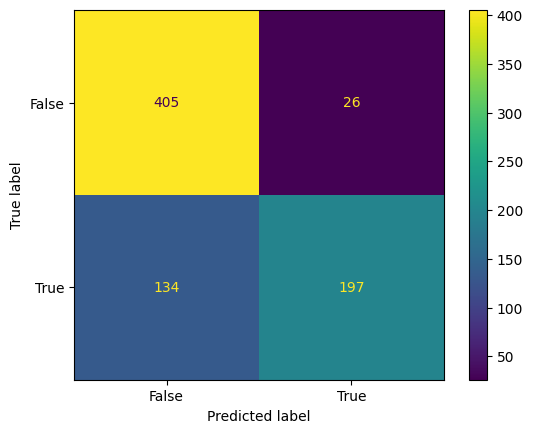

{'F1_Score': 0.7111913357400722,
 'Accuracy': 0.7900262467191601,
 'Precision': 0.8834080717488789,
 'Recall': 0.595166163141994}

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(val_label, y_pred_0)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()
model_0_results = results(val_label, y_pred_0)
model_0_results

#Making the simple dense model 1

In [ ]:
from helper_functions import create_tensorboard_callback

save_dir = "model_logs"

In [ ]:
from tensorflow.keras import layers

# inputs = tf.keras.Input((1,), dtype = tf.string)

# x = text_vectorizer(inputs)
# x = embedding(x)
# outputs = layers.Dense(1, activation = "sigmoid")(x)

# model_1_dense = tf.keras.Model(inputs, outputs)

In [ ]:
# model_1_dense.summary()

the above model gives 1 output for each token (15 tokens per input)
So we get 15 outputs for each input text in the above model. So we need to use global average pooling to convert it into one when passing to dense layer. 

In [ ]:
inputs = tf.keras.Input((1,), dtype = tf.string)

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model_1_dense = tf.keras.Model(inputs, outputs)

In [ ]:
model_1_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

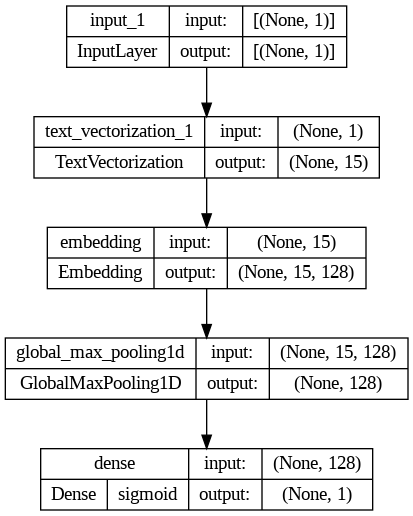

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_1_dense,  show_shapes=True, show_layer_activations=True)

In [ ]:
from helper_functions import create_tensorboard_callback

model_1_dense.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["Accuracy"]
)

In [ ]:
model_1_dense.fit(train_text, train_label,
                  epochs = 5,
                  validation_data = (val_text, val_label),
                  callbacks = [create_tensorboard_callback(
                      save_dir,
                      experiment_name="simple_dense_model"
                  )]
                  )

Saving TensorBoard log files to: model_logs/simple_dense_model/20230604-154835
Epoch 1/5
215/215 [==============================] - 33s 128ms/step - loss: 0.6356 - Accuracy: 0.6600 - val_loss: 0.5695 - val_Accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4660 - Accuracy: 0.8302 - val_loss: 0.4756 - val_Accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3379 - Accuracy: 0.8767 - val_loss: 0.4558 - val_Accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2547 - Accuracy: 0.9098 - val_loss: 0.4629 - val_Accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1935 - Accuracy: 0.9371 - val_loss: 0.4818 - val_Accuracy: 0.7953


In [ ]:
model_1_dense.evaluate(val_text, val_label)

24/24 [==============================] - 0s 3ms/step - loss: 0.4818 - Accuracy: 0.7953


[0.4818490147590637, 0.7952755689620972]

In [ ]:
model_1_pred = model_1_dense.predict(val_text)
model_1_pred[:5]

24/24 [==============================] - 0s 2ms/step


array([[0.99883276],
       [0.03701368],
       [0.0620705 ],
       [0.22718771],
       [0.4878336 ]], dtype=float32)

In [ ]:
model_1_pred_f = tf.squeeze(tf.round(model_1_pred))
model_1_pred_f.shape

TensorShape([762])

In [ ]:
model_1_results = results(val_label, model_1_pred_f)
model_1_results

{'F1_Score': 0.7499999999999999,
 'Accuracy': 0.7952755905511811,
 'Precision': 0.7986348122866894,
 'Recall': 0.7069486404833837}

**Visualising learned embeddings**

In [ ]:
len(words_in_vocab)

10000

In [ ]:
embedding_weights = model_1_dense.get_layer("embedding").get_weights()[0] # 0 coz its a list of 1 array element
embedding_weights.shape

(10000, 128)

#Embedding vector tool to visualize embeddings

http://projector.tensorflow.org/

In [ ]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0: 
#      continue # skip padding token
#   vec = embedding_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

In [ ]:
# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

#model 2 LSTM

In [ ]:
inputs = layers.Input((1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)

x = layers.LSTM(64, return_sequences=True)(x)

x = layers.LSTM(64)(x)

# x = layers.Dense(64, activation = "relu")(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)

model_2_lstm = tf.keras.Model(inputs, outputs)
model_2_lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                           

In [ ]:
model_2_lstm.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
model_2_history = model_2_lstm.fit(
    train_text,  train_label,
    epochs = 5,
    validation_data = (val_text, val_label),
    callbacks = [create_tensorboard_callback(save_dir, "model_2_lstm")]
)

Saving TensorBoard log files to: model_logs/model_2_lstm/20230604-154959
Epoch 1/5
215/215 [==============================] - 17s 54ms/step - loss: 0.3728 - accuracy: 0.8323 - val_loss: 0.4818 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2417 - accuracy: 0.9032 - val_loss: 0.6141 - val_accuracy: 0.7546
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1706 - accuracy: 0.9368 - val_loss: 0.7080 - val_accuracy: 0.7428
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1268 - accuracy: 0.9548 - val_loss: 0.7309 - val_accuracy: 0.7454
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0909 - accuracy: 0.9651 - val_loss: 1.0316 - val_accuracy: 0.7388


In [ ]:
model_2_pred_probs = model_2_lstm.predict(val_text)
model_2_pred_probs = tf.squeeze(tf.round(model_2_pred_probs))
model_2_pred_probs[:5]

24/24 [==============================] - 1s 5ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 0., 0., 0., 1.], dtype=float32)>

In [ ]:
model_2_results = results(val_label, model_2_pred_probs)
model_2_results

{'F1_Score': 0.7016491754122939,
 'Accuracy': 0.7388451443569554,
 'Precision': 0.6964285714285714,
 'Recall': 0.7069486404833837}

In [ ]:
model_0_results

{'F1_Score': 0.7111913357400722,
 'Accuracy': 0.7900262467191601,
 'Precision': 0.8834080717488789,
 'Recall': 0.595166163141994}

about GRU - Understanding GRU networks - towards datascience

GRU is similar to LSTM but has less parameters.

In [ ]:


inputs = layers.Input(shape=(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)

# x = layers.GRU(64, return_sequences = True)(x)
x = layers.GRU(64)(x)
# x = layers.LSTM(64, return_sequences = True)(x)

# x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)

model_03_gru = tf.keras.Model(inputs, outputs)

In [ ]:
model_03_gru.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

In [ ]:
model_03_gru.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
model_3_history = model_03_gru.fit(
    train_text, train_label,
    epochs = 5,
    validation_data = (val_text, val_label),
     callbacks = [create_tensorboard_callback(save_dir, "model_3_gru_test")]
)

Saving TensorBoard log files to: model_logs/model_3_gru_test/20230604-155045
Epoch 1/5
215/215 [==============================] - 15s 54ms/step - loss: 0.2092 - accuracy: 0.9111 - val_loss: 0.7661 - val_accuracy: 0.7270
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0992 - accuracy: 0.9625 - val_loss: 0.8036 - val_accuracy: 0.7454
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0761 - accuracy: 0.9705 - val_loss: 1.0314 - val_accuracy: 0.7441
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0613 - accuracy: 0.9730 - val_loss: 1.1914 - val_accuracy: 0.7152
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0506 - accuracy: 0.9742 - val_loss: 1.3663 - val_accuracy: 0.7388


In [ ]:
model_3_pred_probs = model_03_gru.predict(val_text)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[9.9994910e-01],
        [6.7092304e-05],
        [5.6919580e-05],
        [1.0863293e-03],
        [9.9961370e-01],
        [7.2230417e-01],
        [9.6429563e-01],
        [9.9414426e-01],
        [1.4905000e-01],
        [2.4107298e-01]], dtype=float32))

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 1., 1., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
model_3_results = results(y_true=val_label, 
                                    y_pred=model_3_preds)
model_3_results

{'F1_Score': 0.6875981161695448,
 'Accuracy': 0.7388451443569554,
 'Precision': 0.7156862745098039,
 'Recall': 0.6616314199395771}

In [ ]:
inputs = layers.Input(shape=(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)

model_04_bid = tf.keras.Model(inputs, outputs)

In [ ]:
model_04_bid.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["Accuracy"]
)

In [ ]:
model_04_bid.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [ ]:
model_04_bid.fit(
    train_text,
    train_label,
    epochs = 5,
    validation_data = (val_text, val_label),
    callbacks = [create_tensorboard_callback(save_dir, "model_04_bidirectional")]
)

Saving TensorBoard log files to: model_logs/model_04_bidirectional/20230604-155110
Epoch 1/5
215/215 [==============================] - 17s 56ms/step - loss: 0.1351 - Accuracy: 0.9553 - val_loss: 0.8470 - val_Accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0607 - Accuracy: 0.9721 - val_loss: 1.2354 - val_Accuracy: 0.7441
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0545 - Accuracy: 0.9755 - val_loss: 1.1510 - val_Accuracy: 0.7402
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0507 - Accuracy: 0.9772 - val_loss: 1.3023 - val_Accuracy: 0.7441
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0436 - Accuracy: 0.9772 - val_loss: 1.3883 - val_Accuracy: 0.7323


In [ ]:
model_04_pred_probs = model_04_bid.predict(val_text)
model_04_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[9.9997914e-01],
       [2.7260152e-04],
       [1.1663601e-05],
       [1.8680416e-02],
       [9.9983168e-01],
       [7.9537851e-01],
       [7.0353562e-01],
       [9.9906451e-01],
       [1.3138428e-02],
       [3.7076569e-01]], dtype=float32)

In [ ]:
model_04_preds = tf.round(tf.squeeze(model_04_pred_probs))
model_04_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 1., 1., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
model_4_results = results(val_label, model_04_preds)
model_4_results

{'F1_Score': 0.6890243902439024,
 'Accuracy': 0.7322834645669292,
 'Precision': 0.6953846153846154,
 'Recall': 0.6827794561933535}

In [ ]:
model_1_results

{'F1_Score': 0.7499999999999999,
 'Accuracy': 0.7952755905511811,
 'Precision': 0.7986348122866894,
 'Recall': 0.7069486404833837}

In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Conv1D(filters = 64, kernel_size = 6, activation = "relu")(x)
print(x.shape)
x = layers.GlobalMaxPool1D()(x)
print(x.shape)

(None, 15, 128)
(None, 10, 64)
(None, 64)


In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64, kernel_size = 6, activation = "relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_05_conv1d = tf.keras.Model(inputs, outputs)


model_05_conv1d.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["Accuracy"]
)

model_05_conv1d.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            49216     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [ ]:
model_05_conv1d.fit(
    train_text, 
    train_label,
    epochs = 5,
    validation_data = (val_text, val_label),
    callbacks = [create_tensorboard_callback(
        save_dir, "model_05_conv1d"
    )]
)

Saving TensorBoard log files to: model_logs/model_05_conv1d/20230604-155156
Epoch 1/5
215/215 [==============================] - 18s 56ms/step - loss: 0.1415 - Accuracy: 0.9521 - val_loss: 0.9418 - val_Accuracy: 0.7454
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0748 - Accuracy: 0.9727 - val_loss: 1.0517 - val_Accuracy: 0.7362
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0604 - Accuracy: 0.9755 - val_loss: 1.1450 - val_Accuracy: 0.7244
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0534 - Accuracy: 0.9797 - val_loss: 1.1887 - val_Accuracy: 0.7283
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0506 - Accuracy: 0.9783 - val_loss: 1.2652 - val_Accuracy: 0.7283


In [ ]:
model_0_results

{'F1_Score': 0.7111913357400722,
 'Accuracy': 0.7900262467191601,
 'Precision': 0.8834080717488789,
 'Recall': 0.595166163141994}

In [ ]:
model_5_pred_probs = model_05_conv1d.predict(val_text)
model_5_pred = tf.round(tf.squeeze(model_5_pred_probs))
model_5_results = results(val_label, model_5_pred)
model_5_results

24/24 [==============================] - 0s 2ms/step


{'F1_Score': 0.6800618238021638,
 'Accuracy': 0.7283464566929134,
 'Precision': 0.6962025316455697,
 'Recall': 0.6646525679758308}

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7ff0dccdd840>

In [ ]:
encoder_l = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                       input_shape = [],
                       dtype = tf.string,
                       trainable = False,
                       name = "USE"
                       )

In [ ]:
model_06_use = tf.keras.Sequential([
    encoder_l,
    layers.Dense(128, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
], name = "use_6")

model_06_use.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["Accuracy"]
)

model_06_use.summary()

Model: "use_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_06_use.fit(
    train_text, train_label,
    epochs = 5,
    validation_data = (val_text, val_label),
    callbacks = [create_tensorboard_callback(
        save_dir, "USE_6"
    )]
)

Saving TensorBoard log files to: model_logs/USE_6/20230604-155252
Epoch 1/5
215/215 [==============================] - 9s 15ms/step - loss: 0.4876 - Accuracy: 0.7891 - val_loss: 0.4229 - val_Accuracy: 0.8189
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4113 - Accuracy: 0.8143 - val_loss: 0.4137 - val_Accuracy: 0.8202
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3975 - Accuracy: 0.8235 - val_loss: 0.4086 - val_Accuracy: 0.8294
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3877 - Accuracy: 0.8275 - val_loss: 0.4083 - val_Accuracy: 0.8386
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3789 - Accuracy: 0.8343 - val_loss: 0.4063 - val_Accuracy: 0.8281


In [ ]:
model_6_pred_probs = model_06_use.predict(val_text)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

24/24 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
model_6_results = results(val_label, model_6_preds)
model_6_results

{'F1_Score': 0.7937007874015749,
 'Accuracy': 0.8280839895013123,
 'Precision': 0.8289473684210527,
 'Recall': 0.7613293051359517}

In [ ]:
model_0_results

{'F1_Score': 0.7111913357400722,
 'Accuracy': 0.7900262467191601,
 'Precision': 0.8834080717488789,
 'Recall': 0.595166163141994}

In [ ]:
train_shuffeled.head()

,id,keyword,location,text,target
4055,5760,forest%20fires,Tips on my blog at,Tales of the #trees #deep water loving #Lake T...,0
5199,7424,obliterated,"Palmyra, NJ",I was obliterated last night??,0
5735,8184,rescuers,NaN,Woman's GPS app guides rescuers to injured bik...,1
5263,7525,oil%20spill,"England, Great Britain.",National Briefing | West: California: Spring O...,1
764,1105,blew%20up,NaN,Queens Gambit went well until Anakin blew up t...,0


In [ ]:
# train_shuffeled_10p = train_shuffeled[["text", "target"]].sample(frac = 0.1, random_state = 8)

# train_text_10p = train_shuffeled_10p["text"].to_list()
# train_label_10p = train_shuffeled_10p["target"].to_list()
# train_text_10p[:10], train_label_10p[:10]

In [ ]:
split = round(len(train_text) * 0.1)
split

685

In [ ]:
train_text_10p = train_text[:split]
train_label_10p = train_label[:split]
train_text_10p.shape

(685,)

In [ ]:
model_07_10p = tf.keras.Sequential([
    encoder_l,
    layers.Dense(128, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
], name = "use_6")

model_07_10p.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["Accuracy"]
)

model_07_10p.summary()

Model: "use_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_07_10p.fit(
    train_text_10p, train_label_10p,
    epochs = 10 ,
    validation_data = (val_text, val_label),
    callbacks = [create_tensorboard_callback(save_dir, "USE on 10 percent")]
)

Saving TensorBoard log files to: model_logs/USE on 10 percent/20230604-155314
Epoch 1/10
22/22 [==============================] - 3s 46ms/step - loss: 0.6595 - Accuracy: 0.6905 - val_loss: 0.6221 - val_Accuracy: 0.7638
Epoch 2/10
22/22 [==============================] - 1s 26ms/step - loss: 0.5657 - Accuracy: 0.8131 - val_loss: 0.5467 - val_Accuracy: 0.7769
Epoch 3/10
22/22 [==============================] - 1s 26ms/step - loss: 0.4816 - Accuracy: 0.8161 - val_loss: 0.4975 - val_Accuracy: 0.7848
Epoch 4/10
22/22 [==============================] - 0s 22ms/step - loss: 0.4278 - Accuracy: 0.8146 - val_loss: 0.4775 - val_Accuracy: 0.7861
Epoch 5/10
22/22 [==============================] - 0s 21ms/step - loss: 0.3912 - Accuracy: 0.8321 - val_loss: 0.4695 - val_Accuracy: 0.7900
Epoch 6/10
22/22 [==============================] - 0s 22ms/step - loss: 0.3651 - Accuracy: 0.8380 - val_loss: 0.4679 - val_Accuracy: 0.7913
Epoch 7/10
22/22 [==============================] - 1s 26ms/step - loss: 0.3

In [ ]:
model_7_pred_probs = model_07_10p.predict(val_text)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = results(val_label, model_7_preds)

24/24 [==============================] - 1s 9ms/step


In [ ]:
model_7_results

{'F1_Score': 0.742671009771987,
 'Accuracy': 0.7926509186351706,
 'Precision': 0.8056537102473498,
 'Recall': 0.6888217522658611}

In [ ]:
model_6_results

{'F1_Score': 0.7937007874015749,
 'Accuracy': 0.8280839895013123,
 'Precision': 0.8289473684210527,
 'Recall': 0.7613293051359517}

In [ ]:
# model_07_clone = tf.keras.models.clone_model(model_06_use)

# model_07_clone.compile(
#     loss = "binary_crossentropy",
#     optimizer = tf.keras.optimizers.Adam(),
#     metrics = ["Accuracy"]
# )

In [ ]:
all_model_results = pd.DataFrame({
    "baseline": model_0_results,
    "Dense": model_1_results,
    "LSTM": model_2_results,
    "GRU": model_3_results,
    "BiDirectional": model_4_results,
    "Conv1D": model_5_results,
    "USE": model_6_results,
    "USE_10p": model_7_results
}) 
all_model_results = all_model_results.transpose()

In [ ]:
# all_model_results.Accuracy = all_model_results.Accuracy/100

all_model_results

,F1_Score,Accuracy,Precision,Recall
baseline,0.711191,0.790026,0.883408,0.595166
Dense,0.750000,0.795276,0.798635,0.706949
LSTM,0.701649,0.738845,0.696429,0.706949
GRU,0.687598,0.738845,0.715686,0.661631
BiDirectional,0.689024,0.732283,0.695385,0.682779
Conv1D,0.680062,0.728346,0.696203,0.664653
USE,0.793701,0.828084,0.828947,0.761329
USE_10p,0.742671,0.792651,0.805654,0.688822


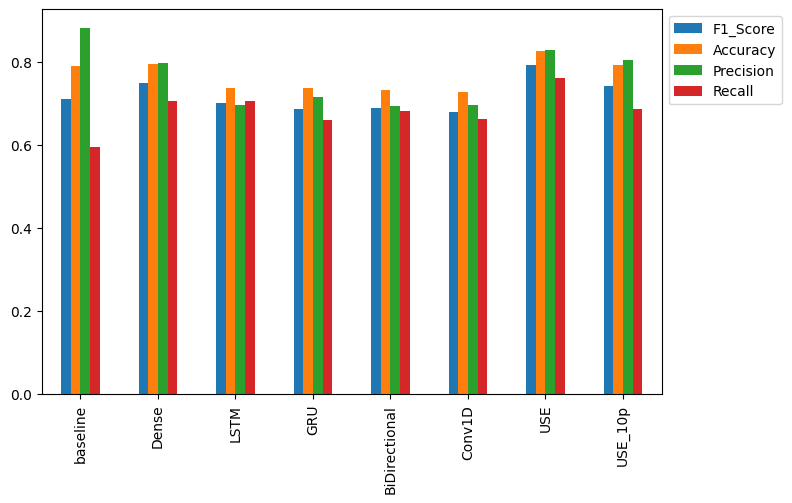

In [ ]:
all_model_results.plot(kind = "bar", figsize = (8,5)).legend(bbox_to_anchor = (1.0, 1.0))

<Axes: >

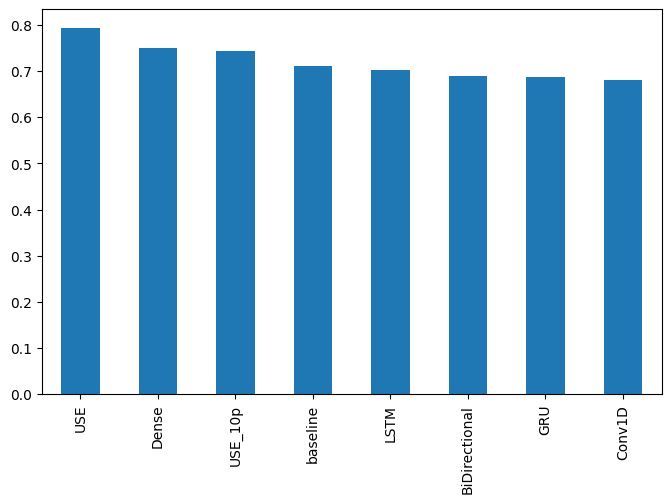

In [ ]:
all_model_results.sort_values("F1_Score", ascending = False)["F1_Score"].plot(kind = "bar", figsize = (8,5))

In [ ]:
model_06_use.save("model_06.h5")

In [ ]:
# import tensorflow_hub as hub

# model_saved = tf.keras.model.load_model("model_06.h5", custom_objects = {"KerasLayer": hub.KerasLayer})

In [ ]:
model_06_use.save("model_06_savedmodel")

In [ ]:
from google.colab import files
files.download("model_06.h5")
files.download("model_06_savedmodel")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
preds_df = pd.DataFrame({
    "text": val_text,
    "target": val_label,
    "preds": model_6_preds,
    "pred_probs": tf.squeeze(model_6_pred_probs)
})

preds_df.tail()

,text,target,preds,pred_probs
757,4 equipment ego break upon dig your family int...,1,0.0,0.070654
758,Mass murderer Che Guevara greeting a woman in ...,1,1.0,0.688349
759,Rocky fire in Northern California swells to 60...,1,1.0,0.983168
760,Experts in France begin examining airplane deb...,1,1.0,0.961183
761,That sounds about right. Our building will hav...,0,1.0,0.909540


In [ ]:
preds_df.text.iloc[760]

'Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wedn... http://t.co/v4SMAESLK5'

In [ ]:
most_wrong = preds_df[preds_df.target != preds_df.preds].sort_values(by ="pred_probs",ascending = False)
most_wrong[-10:]

,text,target,preds,pred_probs
294,Why did I come to work today.. Literally wanna...,1,0.0,0.095404
401,@TheHammers_ @tonycottee1986 alsowhat if some ...,1,0.0,0.089459
663,@pmarca content is held hostage by network due...,1,0.0,0.081512
28,@gilderoy i wish i was good enough to add flam...,1,0.0,0.080932
446,Keeps askin me what this means\nNot like i got...,1,0.0,0.077088
757,4 equipment ego break upon dig your family int...,1,0.0,0.070654
339,Keep shape your shoes ??#Amazon #foot #adjust ...,1,0.0,0.068467
632,Ain't no hoe in my blood,1,0.0,0.055235
237,Reddit Will Now Quarantine Offensive Content h...,1,0.0,0.046410
196,@LEDofficial1 As you can imagine we're inundat...,1,0.0,0.028160


#Predicting test tweets

In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
test_pred_probs = model_06_use.predict(test_df["text"].to_list())
test_pred_probs[:10]

102/102 [==============================] - 1s 8ms/step


array([[0.7416768 ],
       [0.91637444],
       [0.86791855],
       [0.9218342 ],
       [0.9833492 ],
       [0.53697425],
       [0.05772156],
       [0.03780958],
       [0.06045378],
       [0.04037903]], dtype=float32)

In [ ]:
test_preds = tf.squeeze(tf.round(test_pred_probs))
test_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
test_preds.shape, test_df.shape

(TensorShape([3263]), (3263, 4))

In [ ]:
pred_df = pd.DataFrame({"text": test_df["text"], "predicted": test_preds})
pred_df[pred_df.predicted == 0][:10]

,text,predicted
6,They'd probably still show more life than Arse...,0.0
7,Hey! How are you?,0.0
8,What a nice hat?,0.0
9,Fuck off!,0.0
10,No I don't like cold!,0.0
11,NOOOOOOOOO! Don't do that!,0.0
12,No don't tell me that!,0.0
13,What if?!,0.0
14,Awesome!,0.0
16,@sunkxssedharry will you wear shorts for race ...,0.0


In [ ]:
pred_df[pred_df.predicted == 1][:10]